In [18]:
from qiskit import QuantumCircuit
from qiskit.quantum_info import SparsePauliOp
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import QiskitRuntimeService, EstimatorV2 as Estimator
import rsa
import matplotlib as mpl
import numpy as np

In [19]:
nbits = 5

In [20]:
# Generate an RSA keypair
(pubkey, privkey) = rsa.newkeys(128)
print(f'p: {privkey.p}')
print(f'q: {privkey.q}')
print(f'e: {privkey.e}')
print(f'n (public key): {privkey.n}')
print(f'd (private key): {privkey.d}')

p: 266393068637789408201
q: 1001918137499625641
e: 65537
n (public key): 266904047172383899339190971432435281841
d (private key): 249575260064055878403311130075518201473


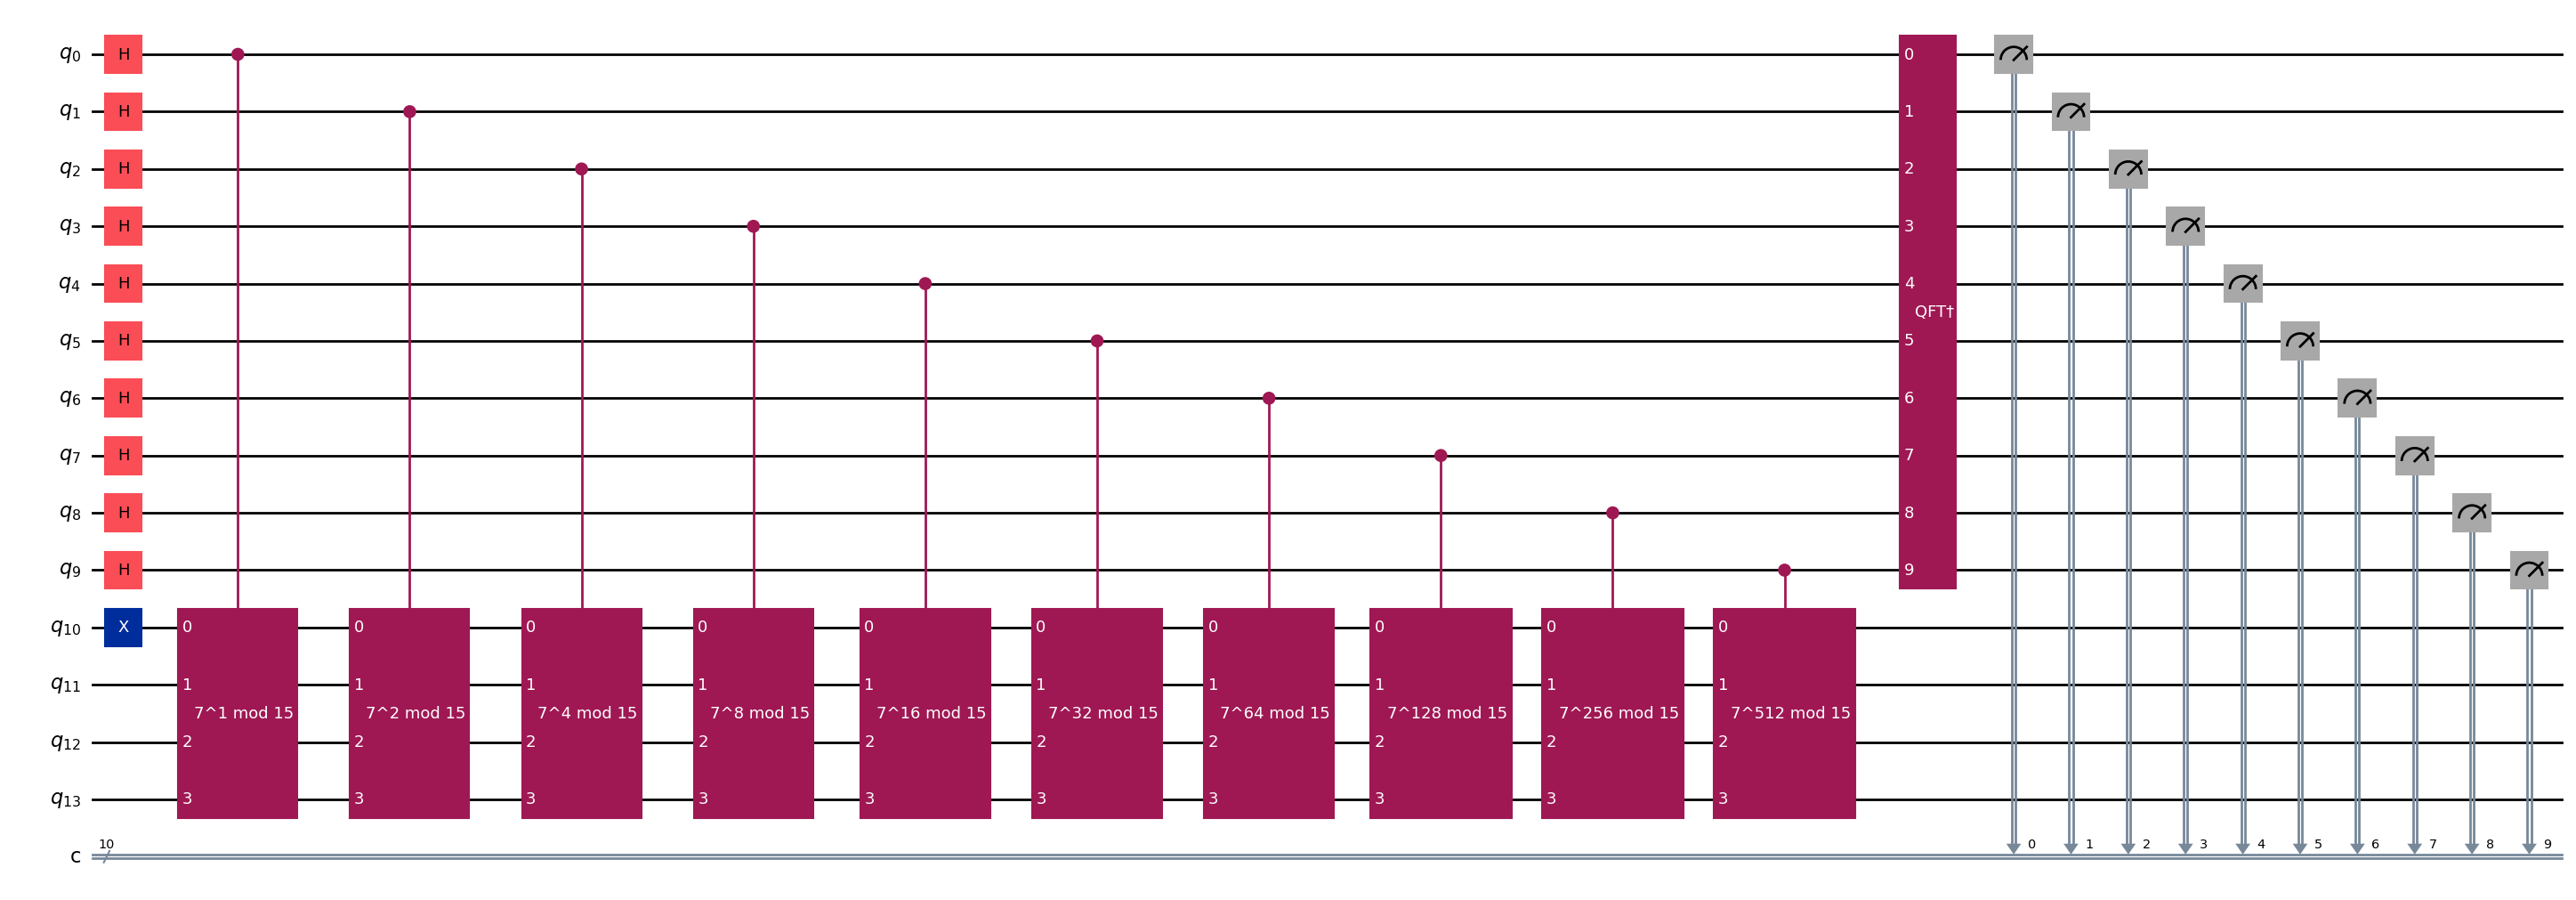

In [21]:
N = 2 * nbits
qc = QuantumCircuit(N + 4, N)
for i in range(N):
    qc.h(i)

def c_amod15(a, power):
    """Controlled multiplication by a mod 15"""
    if a not in [2,4,7,8,11,13]:
        raise ValueError("'a' must be 2,4,7,8,11 or 13")
    U = QuantumCircuit(4)
    for _iteration in range(power):
        if a in [2,13]:
            U.swap(2,3)
            U.swap(1,2)
            U.swap(0,1)
        if a in [7,8]:
            U.swap(0,1)
            U.swap(1,2)
            U.swap(2,3)
        if a in [4, 11]:
            U.swap(1,3)
            U.swap(0,2)
        if a in [7,11,13]:
            for q in range(4):
                U.x(q)
    U = U.to_gate()
    U.name = f"{a}^{power} mod 15"
    c_U = U.control()
    return c_U

def qft_dagger(n):
    """n-qubit QFTdagger the first n qubits in circ"""
    qc = QuantumCircuit(n)
    # Don't forget the Swaps!
    for qubit in range(n//2):
        qc.swap(qubit, n-qubit-1)
    for j in range(n):
        for m in range(j):
            qc.cp(-np.pi/float(2**(j-m)), m, j)
        qc.h(j)
    qc.name = "QFT†"
    return qc

# Create QuantumCircuit with N counting qubits
# plus 4 qubits for U to act on
qc = QuantumCircuit(N + 4, N)

# Initialize counting qubits
# in state |+>
for q in range(N):
    qc.h(q)

# And auxiliary register in state |1>
qc.x(N)

# Do controlled-U operations
for q in range(N):
    qc.append(c_amod15(7, 2**q),
             [q] + [i+N for i in range(4)])

# Do inverse-QFT
qc.append(qft_dagger(N), range(N))

# Measure circuit
qc.measure(range(N), range(N))
qc.draw(fold=-1)  # -1 means 'do not fold'

In [24]:
from qiskit_ibm_runtime import QiskitRuntimeService
service = QiskitRuntimeService(channel="ibm_quantum", token="45e0bc805c6d4a6ea914512f5bae9527c3195cb440793b1f0c63c6eb127161c5ab58ee4514a7e6e4a4a40df84d6663022383c0f6193cbe60a8fbd6c41931ba89")
backend = service.get_backend("ibmq_qasm_simulator")
job = backend.run(qc)